In [25]:
from main import DatasetGenerator
from torch.utils.data import DataLoader
import torch
from main import train
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm
import os
from torchvision import models

loss 0.0123, train acc 0.890, test acc 0.970
410.6 examples/sec on cuda


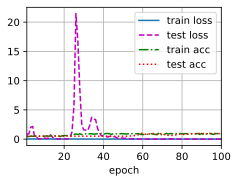

In [26]:
# 初始化数据生成
nsample_perepoch = 100  # 每个epoch的样本数
dataset_train = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 训练数据集
dataset_test = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 测试数据集

# 创建一个DataLoader
data_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)  # 训练数据加载器
test_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)  # 测试数据加载器

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用CUDA设备（如果有）

# 模型和损失历史的输出路径
checkpoint_dir = './checkpoints_resnet18/'

# 加载预训练的ResNet18模型
pretrained_path = '/home/zhangyongxin/深度学习网络/resnet18-f37072fd.pth'
net = models.resnet18(pretrained=False)  # 不加载默认的预训练权重
net.load_state_dict(torch.load(pretrained_path, map_location=device))  # 加载指定的预训练权重

# 修改第一个卷积层以接受单通道输入
net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 修改最后的全连接层以匹配二分类任务
num_classes = 2  # 二分类任务
net.fc = nn.Linear(net.fc.in_features, num_classes)

# 将模型转移到设备上
net.to(device)

# 优化器参数
lr = 0.003  # 学习率
total_epochs = 100  # 总的训练轮数
epoch = 0  # 从头开始训练，因此初始轮数为0
output_freq = 1  # 输出频率

# 初始化训练损失历史记录
train_loss_history = []  # 初始化为空列表

# 训练模型
train(net, lr, nsample_perepoch, epoch, total_epochs,
      dataset_train, data_loader, test_iter,
      train_loss_history=train_loss_history, checkpoint_dir=checkpoint_dir, device=device, notebook=True)

In [27]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from torchvision import models
from torch.utils.data import DataLoader

def evaluate_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数
    y_hat_list = []
    y_list = []
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device).to(torch.float)
            y = y.to(device).to(torch.long)
            y_hat = net(X)
            preds = softmax(y_hat).cpu().numpy()[:, 1].tolist()
            labels = y.cpu().numpy().tolist()
            y_hat_list.extend(preds)
            y_list.extend(labels)
    return np.asarray(y_hat_list), np.asarray(y_list)

def load_trained_model(model_path, device):
    """加载训练好的模型"""
    net = models.resnet18(weights=None)  # 不加载预训练权重
    net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 修改第一个卷积层
    net.fc = nn.Linear(net.fc.in_features, 2)  # 修改最后的全连接层

    checkpoint = torch.load(model_path, map_location=device)
    if "model_state_dict" in checkpoint:
        net.load_state_dict(checkpoint["model_state_dict"])
    else:
        net.load_state_dict(checkpoint)

    net.to(device)
    return net

if __name__ == "__main__":
    model_path = '/home/zhangyongxin/深度学习网络/checkpoints_resnet18/model_e69.pt'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    net = load_trained_model(model_path, device)

    test_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)  # 替换为实际的测试数据加载器
    y_hat_list, y_list = evaluate_gpu(net, test_iter, device=device)

    auc = roc_auc_score(y_list, y_hat_list)
    print(f"AUC: {auc:.4f}")

AUC: 0.9996


In [28]:
nsample_perepoch = 1000 # num of injections
snr = 20  # 信噪比

dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch)
data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)

GPU available? True


In [29]:
# load model
device = torch.device('cuda')
model_path = '/home/zhangyongxin/深度学习网络/checkpoints_resnet18/model_e69.pt'  # 替换为实际的模型路径
net = load_trained_model(model_path, device)

In [30]:
y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

In [31]:
fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
auc = roc_auc_score(y_list, y_hat_list)
auc

0.9775079999999999

In [32]:
index = np.argmax(thresholds < 0.5)

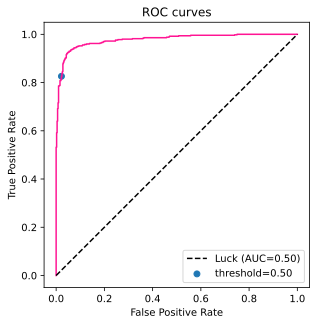

In [33]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color="deeppink")
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
plt.scatter(fpr[index], tpr[index], label=f'threshold={thresholds[index]:.2f}')
plt.axis("square")
# plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 4/4 [09:32<00:00, 143.18s/it]


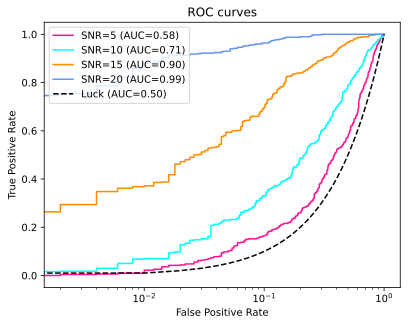

In [34]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

nsample_perepoch = 1000
snr_list = [5, 10, 15, 20]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    plt.plot(fpr, tpr, color=next(colors), label=f'SNR={snr} (AUC={auc:.2f})')
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 3/3 [06:49<00:00, 136.64s/it]


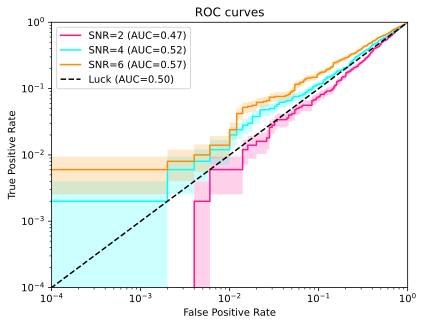

In [35]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

def sigma(n, tp):
    """

    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

nsample_perepoch = 1000
snr_list = [2, 4, 6]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, _ = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    fpr_error = [sigma(len(y_list)/2., t) for t in fpr]
    tpr_error = [sigma(len(y_list)/2., t) for t in tpr]
    
    color = next(colors)
    plt.plot(fpr, tpr, color=color, label=f'SNR={snr} (AUC={auc:.2f})')
    plt.fill_between(fpr, tpr+tpr_error, tpr-tpr_error, alpha=0.2, facecolor=color, zorder=0)
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.xlim(1e-4,1)
plt.ylim(1e-4,1)
plt.legend()
plt.show()